In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

from src import inception_v3_imagenet
from src import imagenet_labels
from src import utils
from src.diff_renderer import make_render_op

In [2]:
%matplotlib inline

In [3]:
w, h = 1000, 1000

In [4]:
mesh = utils.load_obj('resources/dog.obj')
original_texture = mesh.texture_image.copy()
render_op = make_render_op(mesh, w, h)

In [6]:
dir(mesh)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'f',
 'ft',
 'texture_filepath',
 'texture_image',
 'v',
 'vc',
 'vn',
 'vt']

In [12]:
mesh.v.shape

(1338, 3)

In [10]:
mesh.f.shape

(2652, 3)

In [20]:

import opendr
from opendr.serialization import *
from opendr.geometry import *
from opendr.camera import *
from opendr.lighting import *
import numpy as np
import cv2
import chumpy as ch
from chumpy.utils import row, col
from opendr.renderer import *
from src.utils import angles_to_matrix

LIGHT_COMPONENTS = [10.0, 1.0, 1.0]


In [27]:
trans = [0, 0, 2.6]
rotation = [0.4, np.pi+.7, 2.9]
fscale = 0.4
bgcolor = [0.9, 0.9, 0.9]
texture_image = mesh.texture_image

width,height = 1000,1000

# vertices
V = ch.array(mesh.v)
# lighting
A = SphericalHarmonics(vn=VertNormals(v=V, f=mesh.f),
                   components=LIGHT_COMPONENTS,
                   light_color=ch.ones(3))

# center of screen
C = [width/2.,height/2.]

# v = vertices
# f = focal length, fx and fy should be the same
# c = center of screen, should be [w/2, h/2]
# t = translation
# rt = rotation (in Rodrigues format)
# k is for distortions
fmat = [float(width) / float(fscale), float(width) / float(fscale)]
rmat = cv2.Rodrigues(angles_to_matrix(rotation))[0].T[0]
U = ProjectPoints(v=V, f=fmat, c=C, k=ch.zeros(5),
              t=trans, rt=rmat)

# clipping planes, > 0
frustum = {'width': width, 'height': height, 'near': 0.1, 'far': 100.0}

f = TexturedRenderer(vc=A, camera=U, f=mesh.f, bgcolor=bgcolor,
                     texture_image=texture_image, vt=mesh.vt, ft=mesh.ft,
                     frustum=frustum)

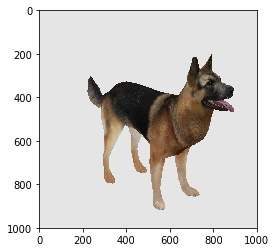

In [31]:
plt.imshow(f.r)

In [36]:
U.camera_mtx

array([[  2.50000000e+03,   0.00000000e+00,   5.00000000e+02],
       [  0.00000000e+00,   2.50000000e+03,   5.00000000e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [43]:
U.view_mtx

array([[ 0.74262977,  0.02322123,  0.66929949,  0.        ],
       [-0.18298798, -0.95433222,  0.23614703,  0.        ],
       [ 0.64421769, -0.29784358, -0.70446631,  2.6       ]])

In [46]:
U.t.r

array([ 0. ,  0. ,  2.6])

In [60]:
U

[[ 364.08742211  458.6235996 ]
 [ 346.28885204  420.02468568]
 [ 367.90214923  417.86771948]
 ..., 
 [ 826.9936563   317.56864249]
 [ 824.24418169  333.41121454]
 [ 823.88321715  314.8104699 ]]

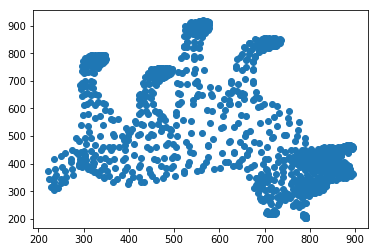

In [64]:
plt.scatter(U.r[:,0],U.r[:,1])

In [63]:
U.r

(1338, 2)

In [ ]:

# v = self.v.r.reshape((-1,3)).copy()
# return cv2.projectPoints(v, self.rt.r, self.t.r, self.camera_mtx, self.k.r)

In [67]:
U.rt.r

array([-2.65706739,  0.12480376, -1.02607004])

In [121]:
# concat the rotation/rodriguez matrix  with the translation matrix
# https://docs.opencv.org/2.4.13.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

abnormal = U.camera_mtx.dot(U.view_mtx).dot(np.hstack((mesh.v[0,:], 1)))
abnormal / abnormal[2]

array([ 364.08742211,  458.6235996 ,    1.        ])

In [116]:
np.hstack((mesh.v[0,:], 1))

array([ 0.04729923, -0.02962504, -0.28196972,  1.        ])

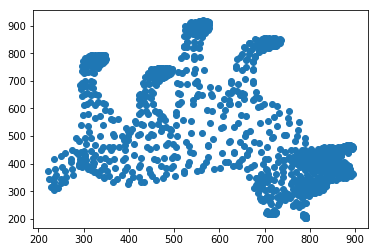

In [101]:
# cv2.projectPoints(objectPoints, rvec, tvec, cameraMatrix, distCoeffs[, imagePoints[, jacobian[, aspectRatio]]])

imagePoints, Jacobian = cv2.projectPoints(mesh.v, U.rt.r, U.t.r, U.camera_mtx, U.k.r)

plt.scatter(imagePoints[:,0,0],imagePoints[:,0,1])

In [112]:
imagePoints

array([[[ 364.08742211,  458.6235996 ]],

       [[ 346.28885204,  420.02468568]],

       [[ 367.90214923,  417.86771948]],

       ..., 
       [[ 826.9936563 ,  317.56864249]],

       [[ 824.24418169,  333.41121454]],

       [[ 823.88321715,  314.8104699 ]]])

In [102]:
U.t.r

array([ 0. ,  0. ,  2.6])

In [83]:
rot_matrix = cv2.Rodrigues(U.rt.r)[0]

In [106]:
imagePoints[0,0,:]

array([ 364.08742211,  458.6235996 ])

In [107]:
np.dot(np.dot(U.camera_mtx, rot_matrix), U.t.r + mesh.v[0,:])

array([  3.16789611e+03,   6.20692465e+02,  -1.59367960e+00])

In [111]:
U.camera_mtx.dot(rot_matrix).dot(mesh.v[0,:])

array([ -2.66744364e+02,   1.54295422e+00,   2.37932796e-01])

In [122]:
angles_to_matrix(rotation)

array([[ 0.74262977,  0.02322123,  0.66929949],
       [-0.18298798, -0.95433222,  0.23614703],
       [ 0.64421769, -0.29784358, -0.70446631]])